In [1]:
%matplotlib inline

In [2]:
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from ipywidgets import interact
from IPython.display import clear_output

In [7]:
# Constants

STATES = 10

IN = 1
HIDDEN = 100
OUT = 3

GAMMA = .9

S = np.array([i for i in range(STATES)])
S_U = S.mean()
S_STD = S.std()

def normalize(s):
    return (s-S_U) / S_STD

def vis_qs():
    q_list = np.array([y.eval({x: [[normalize(s)]]}) for s in S])
    plt.plot(q_list[:,0], c='r')
    plt.plot(q_list[:,1], c='g')
    plt.plot(q_list[:,2], c='b')
    
def policy(qs, eps):
    dist = np.full((OUT), float(eps)/float(OUT))
    dist[np.argmax(qs)] += (1.0 - eps)
    return dist
    
def sample_action(policy):
    return np.random.choice([i for i in range(OUT)], p=policy)

def ds_action(a):
    return [0, -1, 1][a]

def bound(s):
    if s > STATES-1:
        return 0
    elif s < 0:
        return STATES-1
    return s

In [8]:
# Define network

x = tf.placeholder(tf.float32)
t = tf.placeholder(tf.float32)

W1 = tf.Variable(tf.random_normal((HIDDEN, IN)))
b1 = tf.Variable(tf.random_normal((HIDDEN, 1)))

W2 = tf.Variable(tf.random_normal((OUT, HIDDEN)))
b2 = tf.Variable(tf.random_normal((OUT, 1)))

h1 = tf.tanh(tf.matmul(W1, x) + b1)
y = tf.matmul(W2, h1) + b2

cost = tf.reduce_mean(tf.square(y - t))

In [9]:
if 'session' in globals():
    session.close()
    
session = tf.InteractiveSession()
session.run(tf.initialize_all_variables())

In [11]:
train = tf.train.GradientDescentOptimizer(0.01).minimize(cost)

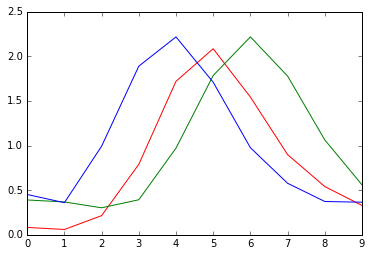

cost 0.000583014


In [12]:
eps = 1.0

for i in range(10000):
    s1 = np.random.randint(STATES)
    
    q1 = y.eval({x: [[normalize(s1)]]})

    # sample action from qs
    a = sample_action(policy(q1, eps))

    # apply action
    s2 = bound(s1 + ds_action(a))

    # get qs
    q2 = y.eval({x: [[normalize(s2)]]})

    reward = 0
    if s2 == 5:
        reward = 1

    # construct target
    target_q = q1
    target_q[a] = reward + GAMMA * q2.T.dot(policy(q2, eps))

    session.run(train, {x: [[normalize(s1)]], t: target_q})
    
    if i % 1000 == 0:
        c = cost.eval({x: [[normalize(s1)]], t: target_q})
        clear_output(wait=True)
        vis_qs()
        plt.show()
        print('cost', c)

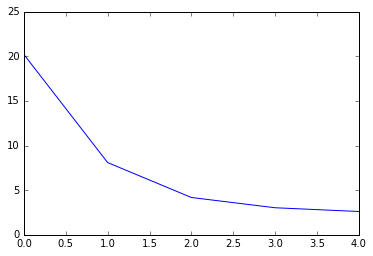

In [14]:
eps = 1.0

def quality(e):
    avg = 0.0
    runs = 100
    for run in range(runs):
        s = np.random.randint(STATES)
        c = 0
        while not (s == 5):
            q1 = y.eval({x: [[normalize(s)]]})

            # sample action from qs
            a = sample_action(policy(q1, e))
            
            # apply action
            s = bound(s + ds_action(a))
            c += 1
            if c > 60:
                break
        avg += float(c) / float(runs)
    return avg
    
q = [quality(e) for e in np.linspace(1.0, 0.0, 5)]

fig = plt.plot(q)

In [16]:
quality(.1)

2.6899999999999986